In [66]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import splat
import numpy
import astropy.units as u
from astropy import constants as const 
import copy
from scipy.integrate import trapz        # for numerical integration
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord, CylindricalDifferential
import pandas as pd
%matplotlib inline

In [2]:
DATA_FOLDER='/users/caganze/research/J1624/data/'

In [3]:
#nearby M dwarfs
df=pd.read_excel(DATA_FOLDER+'UCD_lateM_dwarf_precision_RV_20pc_thin_disk_population.xlsx')

In [4]:
def proper_motion_to_uvw(coord, mu_alpha, mu_delta, rv, pi):
    #coord is a skycoord object
    #v is the velocity vector
    k= 4.74057
    v=np.array([rv, k*mu_alpha/pi, k*mu_delta/pi])
    a, b= coord.icrs.ra.radian, coord.icrs.dec.radian
    T=np.matrix([[-0.06699, -0.87276, -0.48354],
    [0.49273, -0.45035, 0.74458],
    [-0.86760, -0.18837,0.46020]])

    A=np.matrix([[np.cos(a)*np.cos(b), -np.sin(a), -np.cos(a)*np.sin(b)],
       [np.sin(a)*np.cos(b) ,np.cos(a), -np.sin(a)*np.cos(b)],
       [np.sin(b), 0,np.cos(b)]])
    B= T @ A
    
    return B@v



In [5]:
#double-check for trappist one
trap= SkyCoord(ra=346.6250957*u.deg, dec=-5.0428081*u.deg,  
               radial_velocity=-51*u.km/u.s,  pm_ra_cosdec=922.0*u.mas/u.yr,
               pm_dec=-471.9*u.mas/u.yr, distance=12.49*u.pc)
#proper_motion_to_uvw(trap, 922.0*1e-3, 471.9*1e-3, -51.688, 80.09*1e-3)

from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)


In [6]:
trap.galactic.velocity

<CartesianDifferential (d_x, d_y, d_z) in km / s
    (-43.70086526, -65.90881228, 10.3934991)>

In [7]:
coord=SkyCoord(ra=246.0684208*u.deg, dec=-32.2037824*u.deg,
               radial_velocity=0.3*u.km/u.s, pm_ra_cosdec=-25.81*u.mas/u.yr, 
               pm_dec=-185*u.mas/u.yr, distance=16.7*u.pc)
#rv_unc=0.13

#rvs=np.random.normal(0.3, 0.13, 1000)

#ms=np.array([proper_motion_to_uvw(coord, x, -25.81/100, -185.78) for x in rvs])

In [8]:
tarvx, tarvy, tarvz=coord.galactic.velocity.d_x, coord.galactic.velocity.d_y, coord.galactic.velocity.d_z

In [9]:
#u

In [10]:
#m, mer=np.nanmedian(ms, axis=0), np.nanstd(ms, axis=0)


In [11]:
#m=m.flatten()
#mer=mer.flatten()

In [12]:
#kiman catalog
#kiman catalog
data=pd.read_hdf(DATA_FOLDER+'/merged_Mdwarfs.h5', key='merged')

In [13]:
mask=np.logical_and.reduce([data.photometric_sample_subg !=0,
                            data.photometric_sample_subred !=0,
                            data.GOODPHOT_SDSS ==1, 
                            data.GOODMATCH==1,
                            abs(data.parallax_error/data.parallax)<0.2,
                           data.SPT_x <8.])

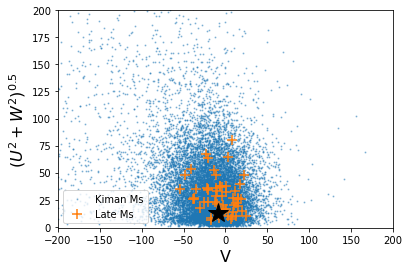

In [14]:
fig, ax=plt.subplots()

plt.scatter(data.V[mask], ((data.U**2+data.W)**0.5)[mask], s=1, alpha=0.4, label='Kiman Ms')
#plt.scatter(data.VZ, (data.VX**2+data.VY)**0.5, s=1, alpha=0.4, label='Kiman Ms')
plt.scatter(df.V, (df.U**2+df.W**2)**0.5, s=100, marker='+', label='Late Ms')
ax.errorbar(tarvz.value, (tarvx.value**2+ tarvy.value**2)**0.5, ms=20,  fmt='*', color='k')
plt.xlim([-200, 200])
plt.ylim([-1, 200])
plt.xlabel('V', fontsize=16)
plt.ylabel(r'$(U^2+ W^2)^{0.5}$', fontsize=16)
plt.legend(loc='lower left')


In [15]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1 
gcs=Vizier.get_catalogs('J/A+A/530/A138')


In [16]:
metal=(0.29, 0.07)

In [17]:

gcs_df=gcs[0].to_pandas()

In [18]:
gcs_bools=gcs_df['__Fe_H_'].between(metal[0]-3*metal[-1], metal[0]+3*metal[-1] )

In [19]:
metal[0]-3*metal[-1],

(0.07999999999999996,)

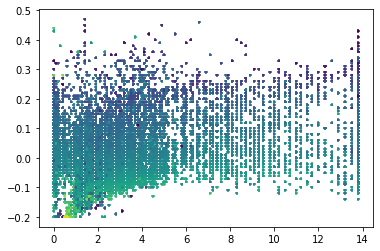

In [20]:
fig, ax=plt.subplots()
plt.scatter( gcs_df['ageMLP'],gcs_df['__a_Fe_'], c=gcs_df['__Fe_H_'], s=10, marker='+')

Text(0.5, 0, '')

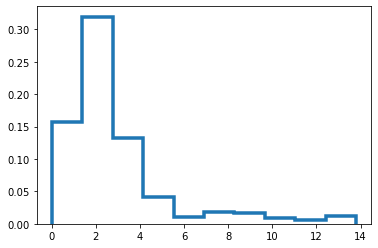

In [21]:
fig, ax=plt.subplots()
#h=ax.hist(gcs[0]['ageMLP'], histtype='step',  lw=3.5, density=True)
h=ax.hist(gcs_df['ageMLP'][gcs_bools],  histtype='step',  lw=3.5, density=True, 
         label='GCS ')
plt.xlabel('')

In [22]:
#plt.plot(gcs[0]['__Fe_H_'], gcs[0]['age'])

In [23]:
#gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import popsims
from gala.units import galactic
from loki import loki

In [24]:
p= popsims.Pointing(coord=coord, name='J1624') 

In [25]:
np.arccos?

In [26]:
#generate distances along this line of sight
#ds=p.draw_distances(0.1, 2000, 350, nsample=1e4)
NPOINTS=int(1e4)
TIMES=int(1e3)
ds=np.random.uniform(0, 2000, NPOINTS)
ux= np.random.uniform(0, 1, NPOINTS)
v=np.random.uniform(0, 1, NPOINTS)
rand_coord=SkyCoord(l=2*np.pi*ux*u.radian, 
                    b=(np.arccos(2*v-1)-np.pi/2)*u.rad, frame='galactic')

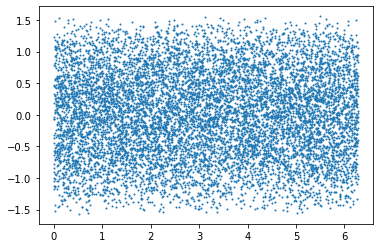

In [27]:
plt.scatter(rand_coord.galactic.l.radian, rand_coord.galactic.b.radian, s=1)

In [28]:
#create new coord object
new_coord= SkyCoord(l=rand_coord.l, b=rand_coord.b, distance=ds*u.pc,
                    radial_velocity=np.random.uniform(-200, 200, len(ds))*u.km/u.s, 
                    frame='galactic')

In [81]:
#new_coord

In [30]:
#m[1]
milky_way = gp.MilkyWayPotential()
H = gp.Hamiltonian(milky_way)
w0 = gd.PhaseSpacePosition(new_coord.cartesian)
orbits=H.integrate_orbit(w0,t=np.logspace(0, 4.1,TIMES)*u.Myr, cython_if_possible=True)


In [76]:
H.integrate_orbit?

In [32]:
vx, vy, vz=orbits.v_xyz

In [82]:
(10**4.2)*u.Myr.to(u.Gyr)

15.848931924611142

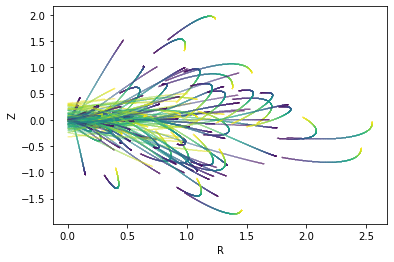

In [34]:
fig, ax=plt.subplots()
rs=(orbits.cartesian.x**2+orbits.cartesian.y**2)**0.5
for idx in np.random.choice(np.arange(0, NPOINTS-1), int(NPOINTS/100)):
    h=plt.scatter(rs[:,idx], orbits.cartesian.z[:,idx], 
               s=1, alpha=.1, marker='+', c=np.log10(orbits.t.value))
    plt.xlabel('R')
    plt.ylabel('Z')

In [35]:
initial=new_coord.galactic.velocity

In [78]:
initial.d_x

<Quantity [-65.23362767, -69.91436543,  91.23060946, ...,  -5.98282034,
            -0.21922662,  -1.31883647] km / s>

In [37]:
mean_vz=np.nanmedian(vz.to(u.km/u.s).value, axis=1)
std_vz=vz.to(u.km/u.s).std(axis=1).to(u.km/u.s).value
mean_z = np.nanmedian(orbits.cartesian.z.to(u.pc).value, axis=1)
std_z=np.nanstd(orbits.cartesian.z.to(u.pc).value, axis=1)

In [38]:
weights= np.abs(orbits.cartesian.z.to(u.pc).value) <20

In [39]:
weighted_vz= np.nanmedian(vz.to(u.km/u.s).value*weights, axis=1)
weighted_z= np.nanmedian(orbits.cartesian.z.to(u.pc).value*weights, axis=1)

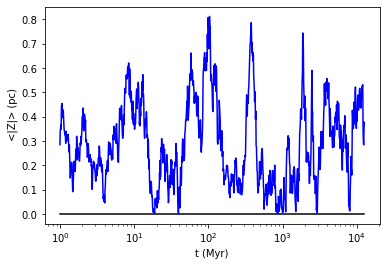

In [40]:
fig, ax=plt.subplots()
#for idx in np.random.choice(np.arange(0, 9000), 5000):
h=ax.plot(orbits.t.value, abs(weighted_vz),
       alpha=1.,  c='k')
h=ax.plot(orbits.t.value, abs(mean_vz),
       alpha=1.,  c='b')
#ax.fill_between(orbits.t.value, mean_z - std_z, mean_z + std_z, alpha=0.2, 
#                color='r')
#ax.axhline(coord.cartesian.z.to(u.pc).value)

plt.xlabel('t (Myr)')
plt.ylabel(r' <|Z|> (pc)')
#plt.yscale('log')
plt.xscale('log')

In [41]:
total_time= weights.T @ orbits.t.value.flatten()/(NPOINTS)

In [42]:
np.shape(weights.T), len(total_time), total_time.max()

((10000, 1000), 10000, 133.83885259353536)

In [43]:
total_time

array([1.41754334e+01, 7.43786304e-02, 1.33838853e+02, ...,
       3.68073625e-01, 1.01991607e+00, 0.00000000e+00])

Text(0.5, 0, 't within 20 pc (Myr)')

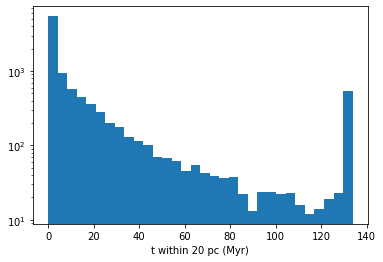

In [74]:
fig, ax=plt.subplots()
#for idx in np.random.choice(np.arange(0, 9000), 5000):
h=ax.hist(total_time, bins=32, log=True)
#ax.fill_between(orbits.t.value, mean_z - std_z, mean_z + std_z, alpha=0.2, 
#                color='r')
#ax.axhline(coord.cartesian.z.to(u.pc).value)

plt.xlabel('t within 20 pc (Myr)')
#plt.ylabel(r' <|Z|> (pc)')
#plt.xscale('log')

Text(0, 0.5, ' <VZ> (km/s)')

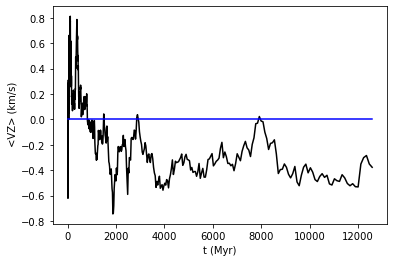

In [45]:
fig, ax=plt.subplots()
#for idx in np.random.choice(np.arange(0, 9000), 5000):
h=ax.plot(orbits.t.value, mean_vz,
       alpha=1.,  c='k')
#ax.fill_between(orbits.t.value, mean_z - std_z, mean_z + std_z, alpha=0.2, 
#                color='r')
#ax.axhline(abs(tarvz.to(u.km/u.s).value))
h=ax.plot(orbits.t.value, weighted_vz, c='b')
plt.xlabel('t (Myr)')
plt.ylabel(r' <VZ> (km/s)')
#plt.yscale('log')
#plt.xscale('log')

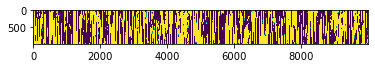

In [46]:
plt.imshow(vz.to(u.km/u.s).value,  vmin=-1, vmax=1)

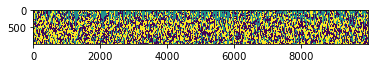

In [47]:
plt.imshow(vz.to(u.km/u.s).value*(weights.astype(int)), vmin=-1, vmax=1)

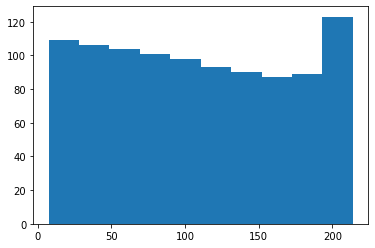

In [48]:
h=plt.hist(vz.to(u.km/u.s).value[:,-1])

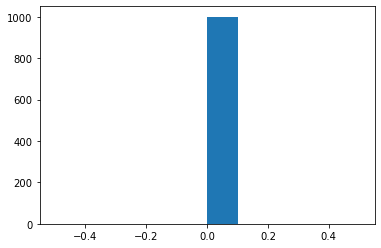

In [49]:
h=plt.hist((vz.to(u.km/u.s).value*weights)[:,-1])

In [68]:
coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (246.0684208, -32.2037824, 16.7)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-25.81, -185., 0.3)>

In [69]:
from astropy.coordinates.representation import SphericalRepresentation, CylindricalRepresentation

In [72]:
cyl=coord.represent_as(CylindricalRepresentation)

In [73]:
cyl.

<CylindricalRepresentation (rho, phi, z) in (pc, rad, pc)
    (14.13083837, -1.98848118, -8.89996668)
 (has differentials w.r.t.: 's')>

In [ ]:
fig, ax=plt.subplots()
#ax.errorbar( data['FEH'][mask2], np.abs(data.W[mask2]), xerr=data['FEH_ERR'][mask2], fmt='o',
#            ms=1., alpha=0.2)
cb=ax.scatter( data['FEH'][mask2], np.abs(data.W[mask2]), c=data['HALPHA'][mask2],
            s=50., vmin=-1, vmax=0.7)
ax.errorbar(0.29, abs(vz.value), xerr= 0.07, ms=20, fmt='*', c='k')
plt.ylim([-1, 100])
plt.colorbar(cb)
#plt.ylim([-1, 1])


In [ ]:
#import sedkit